In [5]:
import pandas as pd
import math
import pyproj

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
def planting_system(csv_filepath, intertree, interrow, gcp_list):
    ''' The function creates a shapefile of orchards tree positions starting from 
    simple User inputs.
    
    :param csv_filepath: filename and saving directory of the created database of tree locs.
    :param intertree: distance (m) between trees in the same row
    :param interrow: distance (m) between tree rows
    :param gcp_list: 5 reference points
    :return: bearing tree row and database filepath
    '''
    
    # saving directory
    csv_file_name = csv_filepath
    # database
    csv_file = pd.DataFrame(columns=["lat", "lon"])

    # get reference points
    point1, point2, point3, point4, point5 = gcp_list
    lat1, lon1 = point1
    lat2, lon2 = point2
    lat3, lon3 = point3
    lat4, lon4 = point4  # max lat reference
    lat5, lon5 = point5  # max lon reference

    # point 3 is on the right side in comparison to point 1 - point 2 line?
    if lon3 > lon2:
        clockwise = True
    else:
        clockwise = False

    # set geo-db CRS
    geodesic = pyproj.Geod(ellps='WGS84')
    
    # get bearing between single row starting and ending points to get an AB line
    # forward azimuth: angle between A and B
    # backword azimuth: angle between B and A
    fwd_azimuth_1to2, back_azimuth, distance = geodesic.inv(lon1, lat1, lon2, lat2)
    ntree_along_the_row = int((distance / intertree))+1


    if lat1 > lat2 and lon1 < lon2:
        if fwd_azimuth_1to2 >= 0:
            bearing = back_azimuth
        else:
            bearing = fwd_azimuth_1to2
    else:
        if fwd_azimuth_1to2 >= 0:
            bearing = fwd_azimuth_1to2
        else:
            bearing = back_azimuth

    print(f'{bearing = }')

    if bearing < 0:
        Inrow_bearing = 360 + bearing
    else:
        Inrow_bearing = bearing

    print(f'{Inrow_bearing = }')

    # get bearing between first - last tree row
    fwd_azimuth_2to3, back_azimuth_2to3, distance = geodesic.inv(lon2, lat2, lon3, lat3)
    nrows = int((distance / interrow))

    if clockwise == True:  # point 3 stands on the right side of AB line
        row_bearing = fwd_azimuth_2to3
        ref_lat = math.radians(lat2)
        ref_lon = math.radians(lon2)
    else:
        row_bearing = back_azimuth_2to3
        ref_lat = math.radians(lat3)
        ref_lon = math.radians(lon3)


    # get first tree of each row considering the bearing between the tree rows'''
    rows = []
    rows.append((math.degrees(ref_lon), math.degrees(ref_lat)))
    for row in range(0, nrows-1):
        print("FINDING TREES\n")
        # a = 0
        '''HAVERSINE FORMULA: error around 0.5% '''
        d = ((interrow) / 1000) * 0.98  # km
        R = 6378.1  # Radius of the Earth  in WGS84 datum
        brng = math.radians(row_bearing)  # Bearing is converted to radians.

        lat2 = math.asin(math.sin(ref_lat) * math.cos(d / R) +
                         math.cos(ref_lat) * math.sin(d / R) * math.cos(brng))

        lon2 = ref_lon + math.atan2(math.sin(brng) * math.sin(d / R) * math.cos(ref_lat),
                                    math.cos(d / R) - math.sin(ref_lat) * math.sin(lat2))

        lat2 = math.degrees(lat2)
        lon2 = math.degrees(lon2)
        rows.append((lon2, lat2))

        if clockwise == True and (lon5 >= lon2):
            ref_lat = math.radians(lat2)
            ref_lon = math.radians(lon2)
        elif clockwise == False and (lon2 >= lon5):
            ref_lat = math.radians(lat2)
            ref_lon = math.radians(lon2)
        else:
            break

    # get trees coordinates considering tree rows parallel to bearing
    brng = math.radians(bearing)

    idx = 0
    for row in rows:
        lon1 = math.radians(row[0])
        lat1 = math.radians(row[1])

        csv_file.loc[idx] = ([math.degrees(lat1), math.degrees(lon1)])
        idx += 1

        for tree in range(0, 3*ntree_along_the_row):
            # print("FINDING TREES\n")
            d = ((intertree) / 1000)  # Km
            R = 6378.1  # Radius of the Earth  in WGS84 datum
            lat2 = math.asin(math.sin(lat1) * math.cos(d / R) +
                             math.cos(lat1) * math.sin(d / R) * math.cos(brng))

            lon2 = lon1 + math.atan2(math.sin(brng) * math.sin(d / R) * math.cos(lat1),
                                     math.cos(d / R) - math.sin(lat1) * math.sin(lat2))

            lat2 = math.degrees(lat2)
            lon2 = math.degrees(lon2)


            # fill the database
            csv_file.loc[idx] = ([lat2, lon2])
            idx += 1

            # change reference starting tree
            if (lat2 <= lat4):
                lat1 = math.radians(lat2)
                lon1 = math.radians(lon2)
            else:
                break

    csv_file.to_csv(csv_file_name, sep=",", index=False)
    return (float(Inrow_bearing), csv_file_name)  # in - row bearing

**inserisci qui sotto le coordinate dei punti**
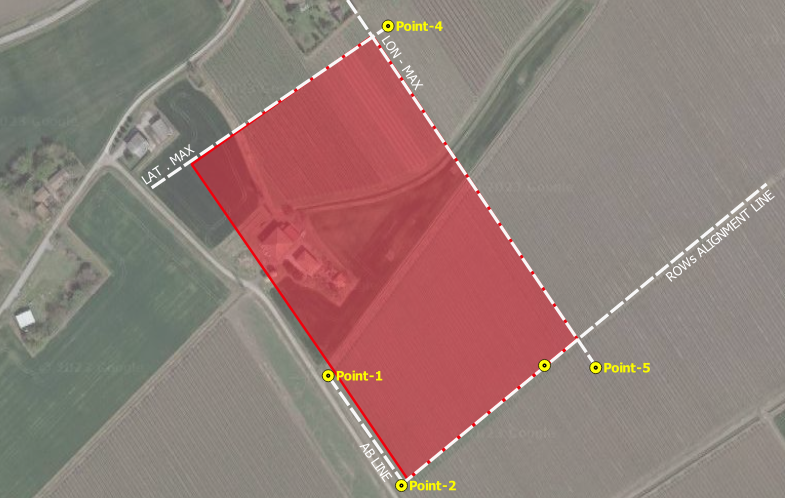

In [12]:
# latitudine, longitudine
p1 = (44.765369, 11.757010)
p2 = (44.764581, 11.757738)
p3 = (44.765563, 11.759384)
p4 = (44.768388, 11.762985)
p5 = (44.769848, 11.761676)

In [ ]:
# enter required inputs
orch_db_fn = input("Scrivi il nome del file:\n ") + '.csv'
INTERTREE = float(input("Distanza SULLA fila (metri):\n "))
INTERROW = float(input("Distanza TRA le file (metri):\n "))

print(orch_db_fn)
# points in (latitude, longitude) format
'''
P1 -> P2 = AB line
                                                      x <----- (point 5 - max Longitude) ------------------> x                  
                  (point 1) ______________________ x <---- (point 4)  ----> x ______________________ (point 1)
                           |                     /                           \                     | 
                           |      field         /              OR             \        field       |
                           |                   /                               \                   |
                  (point 2)|__________________/ (point 3)             (point 3) \__________________| (point 2)
                  
P1 = first row start
P2 = first row end
P3 = last row end
P4 = maximum latitude
P5 = maximum longitude
'''
 # gcp_list = [(P1 lat, P1 lon), (P2 lat, P2 lon), (P3 lat, P3 lon), (P4 lat, P4 lon), (P5 lat, P5 lon)]
gcp_list = [p1, p2, p3, p4, p5]



InRow_bearing, orch_db = planting_system(orch_db_fn, INTERTREE, INTERROW, gcp_list)
print("end")